# Repairing artifacts with ICA and SSP
This notebook covers the basics of independent components analysis (ICA) and Signal Space
Projection (SSP) for artifact repair (here: eye blinks and heart beat). It also demonstrates bad channel interpolation.

In [3]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
# https://mne.tools/stable/auto_tutorials/preprocessing/50_artifact_correction_ssp.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

We begin as always by importing the necessary Python modules and loading some
`example data <sample-dataset>`. Because ICA can be computationally
intense, we'll also crop the data to 60 seconds; and to save ourselves from
repeatedly typing ``mne.preprocessing`` we'll directly import a few functions
and classes from that submodule:

In [4]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [6]:
import os

import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs, compute_proj_eog

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.0).pick(picks=["mag", "eeg", "stim", "eog"])
raw.load_data()

Opening raw data file C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 172 x 9010 (60.0 s), ~14.9 MiB, data loaded>

# Find and interpolate bad channels

In [11]:
# visual inspection of raw data/averaged data/spectra, epoch log, etc.
print(raw.info['bads'])
# visual inspection of raw data
raw.plot(picks='eeg')

# We should definitely mark bad channels as bad:
# (this channel is already marked as bad, we do it here again for illustration)
raw.info['bads'] = ['EEG 053']
# make sure you don't override existing channels. If some channels have already been marked as bad, you can use
# raw.info['bads'].append(['EEG053']) 

['EEG 053']
Channels marked as bad:
['EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


In [12]:
# interpolation (if required)
raw_interp = raw.copy().interpolate_bads()

# check that interpolation works and the previously bad channels now looks like all the others
raw_interp.plot(picks='eeg')

# note: bad channels have been removed from 'info'
print(raw.info['bads'])

Setting channel interpolation method to {'eeg': 'spline', 'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
['EEG 053']
Channels marked as bad:
none


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Note: Interpolation doesn't bring any information back. It only "fills gaps" which may be convenient for further processing steps, e.g. to compute statistics in sensors space and compute grand-averages. If you are performing your main analyses in source space, you don't have to interpolate bad channels (just mark them as bad).

# Eye blink and heart beat artefacts

__Eye blink__ artefacts are notorious in EEG and MEG recordings. They are particularly annoying when they vary systematically with stimulus, task or participant group (e.g. more or earlier blinks in one condition than another). If not avoided or removed, they can end up in source space as well (mostly in frontal brain regions).

__Heart beat__ artefacts are less likely to vary systematically with stimulus or task. In an event-related within-subject design they are usually not a big deal. However, when comparising different participant groups (e.g. controls vs patients, old vs young, etc.), and especially for resting state data, this may be different.


But first things first - let's visualize both eye blink and heart artefacts in our raw data:

In [17]:
# pick some channels that clearly show heartbeats and blinks
regexp = r"(MEG [12][45][123]1|EEG 00.)"
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x1b5a2e3b8b0) at 0x000001B6EBE71480>

Channels marked as bad:
['EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


We can get a summary of how the ocular artifact manifests across each channel
type using `~mne.preprocessing.create_eog_epochs`:



Using EOG channel: EOG 061
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 10 events and 151 original time points 

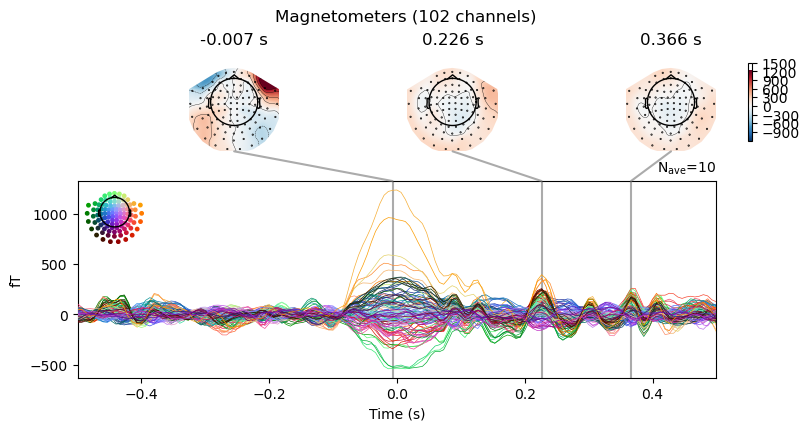

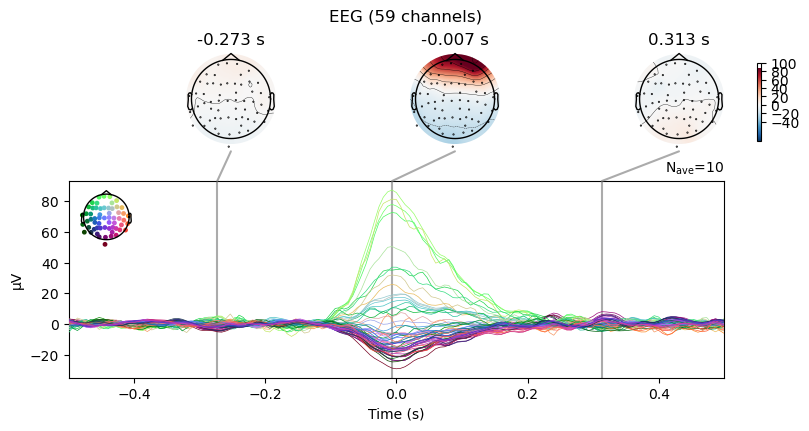

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [15]:
# Time course and topography of eye blinks
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Now we'll do the same for the heartbeat artifacts, using
`~mne.preprocessing.create_ecg_epochs`:



Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

Number of ECG events detected : 59 (average pulse 58.99492412402019 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 59 events and 151 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...


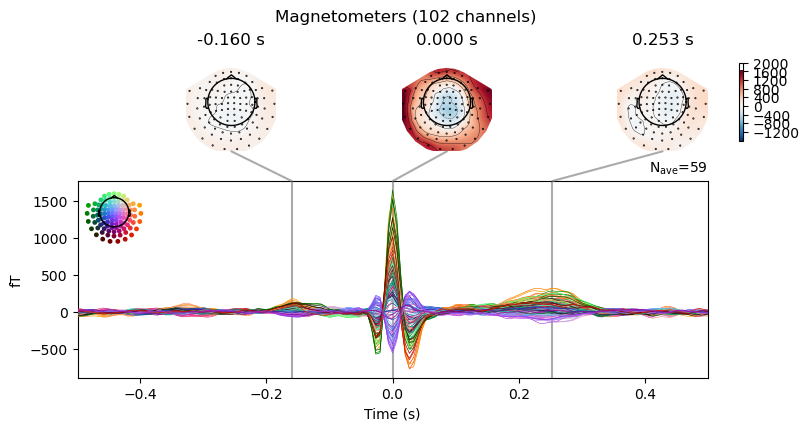

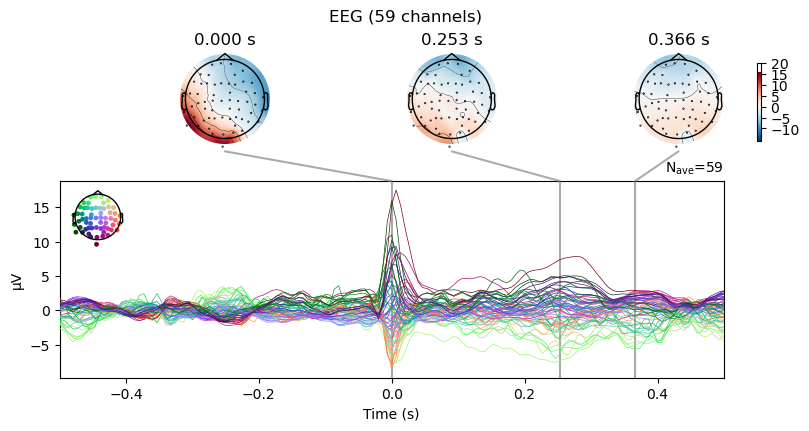

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [18]:
# Time course and topography of heart artefacts
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

### Fitting ICA

In a first step, we are fitting an ICA model to our data to decompose our data into components. In a next step, we decide which of those components to remove (if any).

ICA fitting is not deterministic (e.g., the components may get a sign
flip on different runs, or may not always be returned in the same order), so
we'll also specify a `random seed`_ so that we get identical results each
time this notebook is run.

In [20]:
# High-pass filter raw data to remove slow activity - only to fit the ICA. You can then apply the ICA model to your unfiltered data later.
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [24]:
# Fit the ICA model, i.e. decompose data into ICA components
# note: Here we only fit 15 components to speed things up (see below)
ica = ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,22 iterations on raw data (9010 samples)
ICA components,15
Available PCA components,161
Channel types,"mag, eeg"
ICA components marked for exclusion,—


Some optional parameters that we could have passed to the
`~mne.preprocessing.ICA.fit` method include ``decim`` (to use only
every Nth sample in computing the ICs, which can yield a considerable
speed-up) and ``reject`` (for providing a rejection dictionary for maximum
acceptable peak-to-peak amplitudes for each channel type, just like we used
when creating epoched data in the `tut-overview` tutorial).



### Looking at the ICA solution
Now we can examine the ICs to see what they captured.

Using :meth:`~mne.preprocessing.ICA.get_explained_variance_ratio`, we can
retrieve the fraction of variance in the original data that is explained by
our ICA components in the form of a dictionary:



In [25]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of mag variance explained by all components: 0.9358001342790973
Fraction of eeg variance explained by all components: 0.7798689203334388


The values were calculated for all ICA components jointly, but separately for
each channel type (here: magnetometers and EEG).

We can also explicitly request for which component(s) and channel type(s) to
perform the computation:



In [26]:
# Print explained variance for each ICA component
import numpy as np
for c in np.arange(ica.n_components):
    explained_var_ratio = ica.get_explained_variance_ratio(
        filt_raw, components=[c], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(
        f"Component: "
        f"Fraction of variance in EEG signal explained by component "
        f"{c+1}: "
        f"{ratio_percent}%"
    )
# Note: ICA component are not necessarily ordered by variance

Component: Fraction of variance in EEG signal explained by component 1: 33%
Component: Fraction of variance in EEG signal explained by component 2: 1%
Component: Fraction of variance in EEG signal explained by component 3: 1%
Component: Fraction of variance in EEG signal explained by component 4: 6%
Component: Fraction of variance in EEG signal explained by component 5: 4%
Component: Fraction of variance in EEG signal explained by component 6: 6%
Component: Fraction of variance in EEG signal explained by component 7: 1%
Component: Fraction of variance in EEG signal explained by component 8: 10%
Component: Fraction of variance in EEG signal explained by component 9: 2%
Component: Fraction of variance in EEG signal explained by component 10: 3%
Component: Fraction of variance in EEG signal explained by component 11: 5%
Component: Fraction of variance in EEG signal explained by component 12: 3%
Component: Fraction of variance in EEG signal explained by component 13: 1%
Component: Fraction

`~mne.preprocessing.ICA.plot_sources` will show the time series of the
ICs. Note that in our call to `~mne.preprocessing.ICA.plot_sources` we
can use the original, unfiltered `~mne.io.Raw` object. A helpful tip is that
right clicking (or control + click with a trackpad) on the name of the
component will bring up a plot of its properties. In this plot, you can
also toggle the channel type in the topoplot (if you have multiple channel
types) with 't' and whether the spectrum is log-scaled or not with 'l'.



In [27]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x1b6ddb5cd80) at 0x000001B521666D80>

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Here we can pretty clearly see that the first component (``ICA000``) captures
the EOG signal quite well, and the second component (``ICA001``) looks a lot
like [a heartbeat](qrs_) (for more info on visually identifying Independent
Components, `this EEGLAB tutorial`_ is a good resource). We can also
visualize the scalp field distribution of each component using
`~mne.preprocessing.ICA.plot_components`. These are interpolated based
on the values in the ICA mixing matrix:



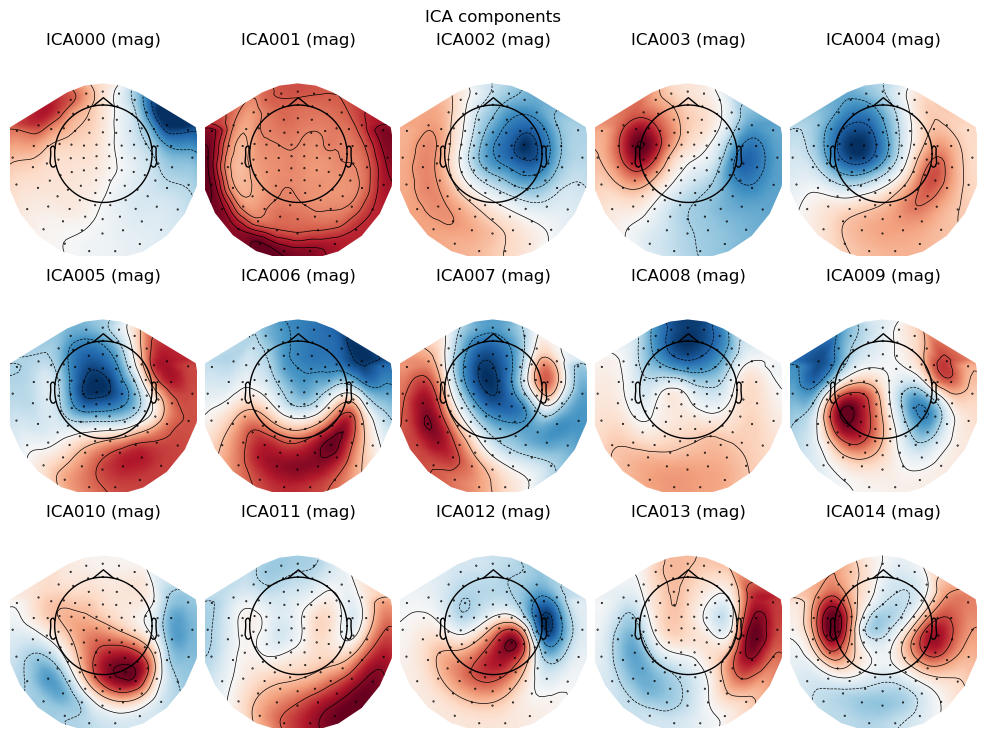

In [28]:
ica.plot_components();

In the plots above it's fairly obvious which ICs are capturing our EOG and
ECG artifacts, but there are additional ways visualize them anyway just to
be sure. First, we can plot an overlay of the original signal against the
reconstructed signal with the artifactual ICs excluded, using
`~mne.preprocessing.ICA.plot_overlay`:



Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


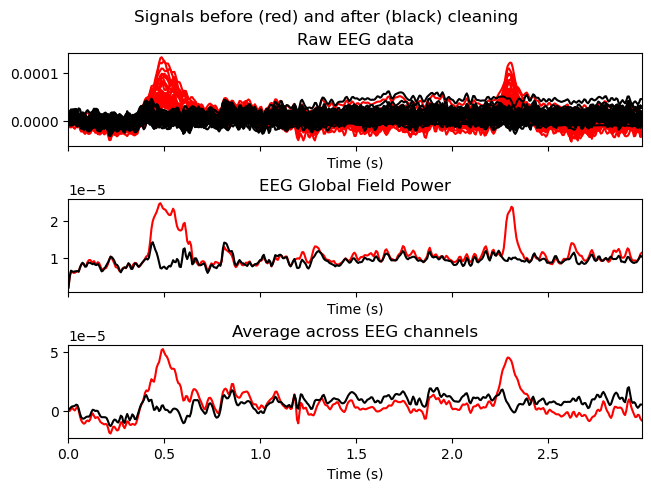

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


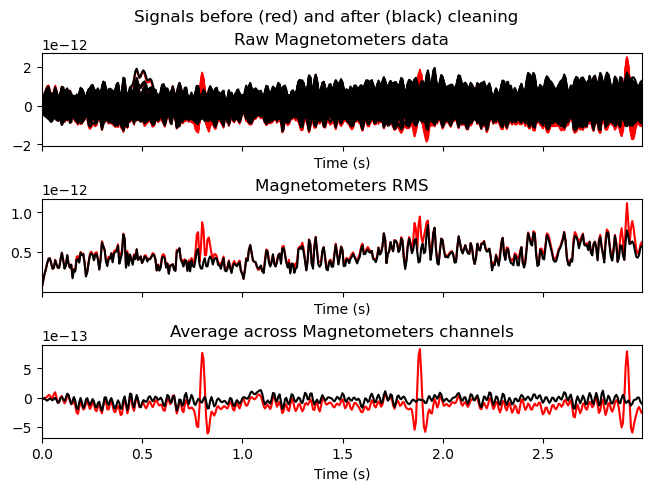

In [29]:
# blinks
ica.plot_overlay(raw, exclude=[0], picks="eeg");
# heartbeats
ica.plot_overlay(raw, exclude=[1], picks="mag");

We can also plot some diagnostics of each IC using
`~mne.preprocessing.ICA.plot_properties`:



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


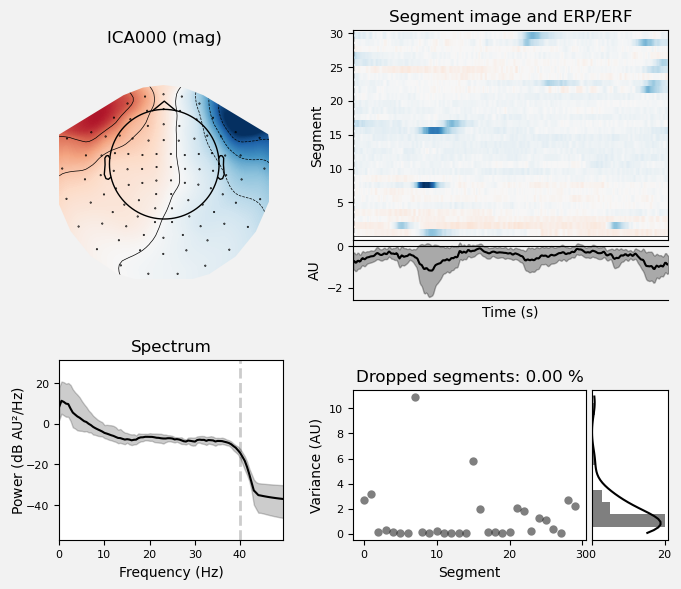

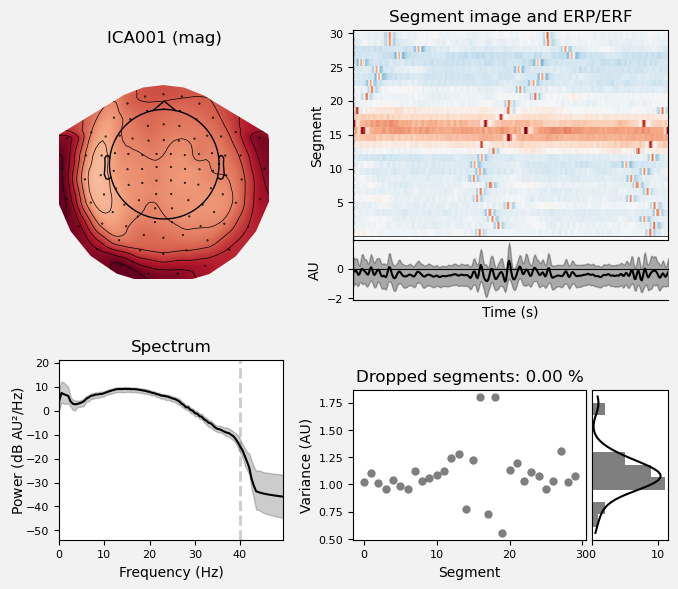

In [30]:
ica.plot_properties(raw, picks=[0, 1]);

In the remaining sections, we'll look at different ways of choosing which ICs
to exclude prior to reconstructing the sensor signals.


### Selecting ICA components manually

Once we're certain which components we want to exclude, we can specify that
manually by setting the ``ica.exclude`` attribute. Similar to marking bad
channels, merely setting ``ica.exclude`` doesn't do anything immediately (it
just adds the excluded ICs to a list that will get used later when it's
needed). Once the exclusions have been set, ICA methods like
`~mne.preprocessing.ICA.plot_overlay` will exclude those component(s)
even if no ``exclude`` parameter is passed, and the list of excluded
components will be preserved when using `mne.preprocessing.ICA.save`
and `mne.preprocessing.read_ica`.



In [31]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

Now that the exclusions have been set, we can reconstruct the sensor signals
with artifacts removed using the `~mne.preprocessing.ICA.apply` method
(remember, we're applying the ICA solution from the *filtered* data to the
original *unfiltered* signal). Plotting the original raw data alongside the
reconstructed data shows that the heartbeat and blink artifacts are repaired.



In [32]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
reconst_raw.plot(
    order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False
)
del reconst_raw

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 161 PCA components
Channels marked as bad:
['EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
['EEG 053']


### Using an ECG channel to select ICA components

It may have seemed easy to review the plots and manually select which ICs to
exclude, but when processing dozens or hundreds of subjects this can become
a tedious, rate-limiting step in the analysis pipeline. One alternative is to
use dedicated EOG or ECG sensors as a "pattern" to check the ICs against, and
automatically mark for exclusion any ICs that match the EOG/ECG pattern. Here
we'll use `~mne.preprocessing.ICA.find_bads_eog` to automatically find
the ICs that best match the EOG signal, then use
`~mne.preprocessing.ICA.plot_scores` along with our other plotting
functions to see which ICs it picked. We'll start by resetting
``ica.exclude`` back to an empty list:



Reconstructing ECG signal from Magnetometers
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff f

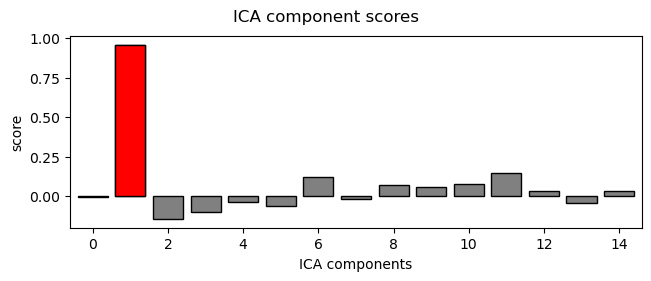

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


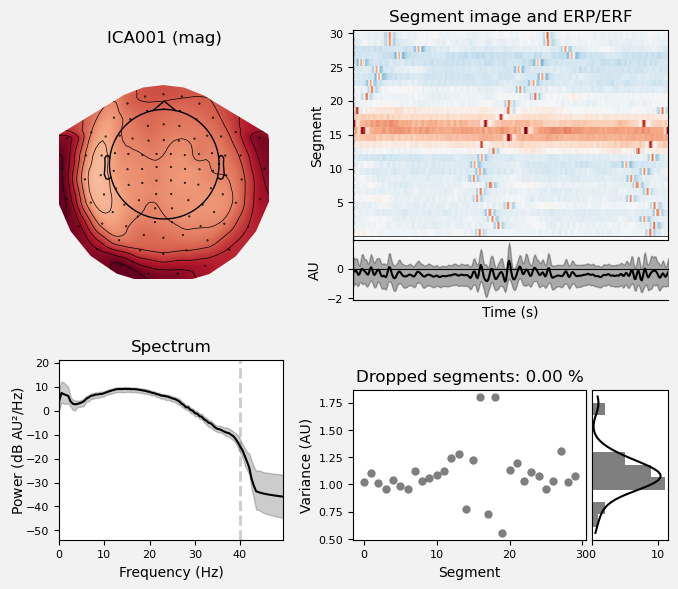

Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


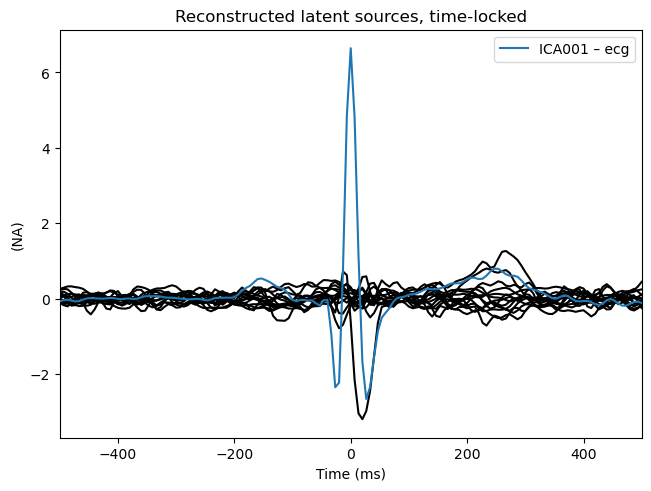

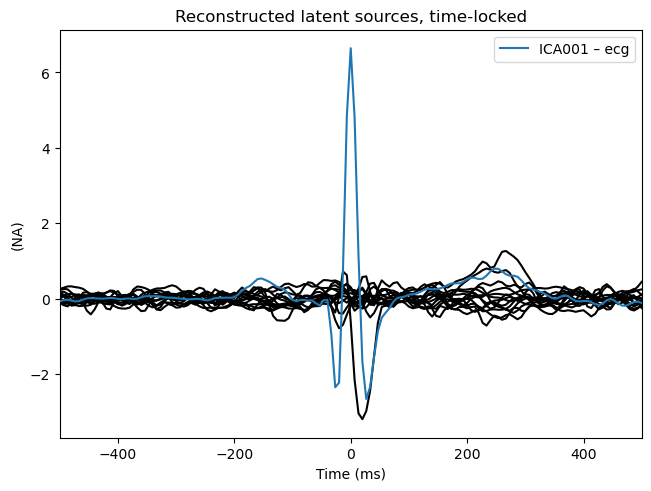

C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


In [33]:
ica.exclude = []
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method="correlation", threshold="auto")
ica.exclude = ecg_indices

# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked)

The last of these plots is especially useful: it shows us that the heartbeat
artifact is coming through on *two* ICs, and we've only caught one of them.
In fact, if we look closely at the output of
`~mne.preprocessing.ICA.plot_sources` (online, you can right-click →
"view image" to zoom in), it looks like ``ICA014`` has a weak periodic
component that is in-phase with ``ICA001``. It might be worthwhile to re-run
the ICA with more components to see if that second heartbeat artifact
resolves out a little better:



15 components may not be enough to capture all the relevant variance for data and artefacts. Let's be more flexible this time:

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by explained variance: 49 components
Fitting ICA took 1.1s.
Reconstructing ECG signal from Magnetometers
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


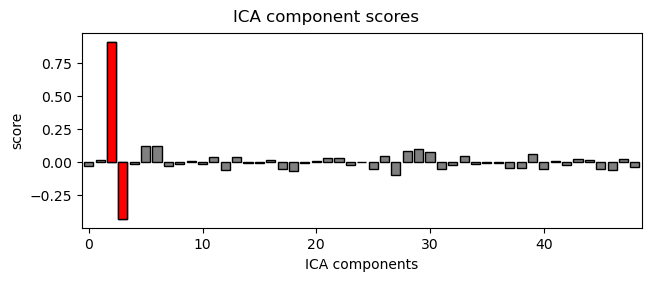

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


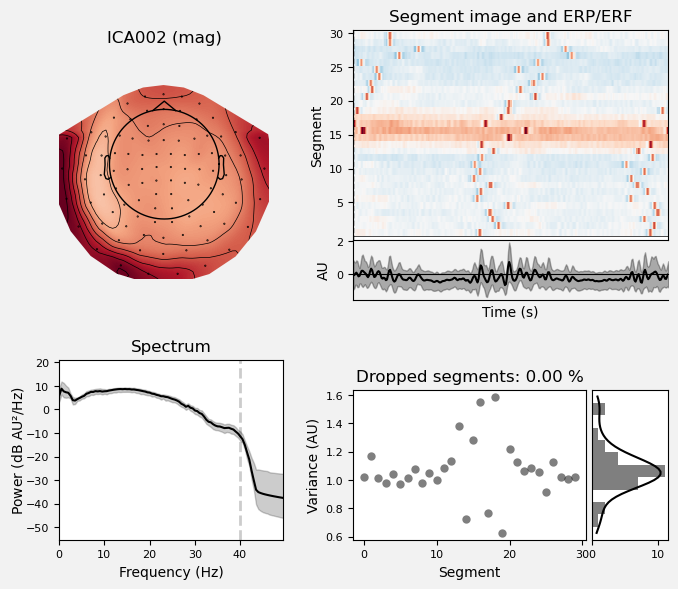

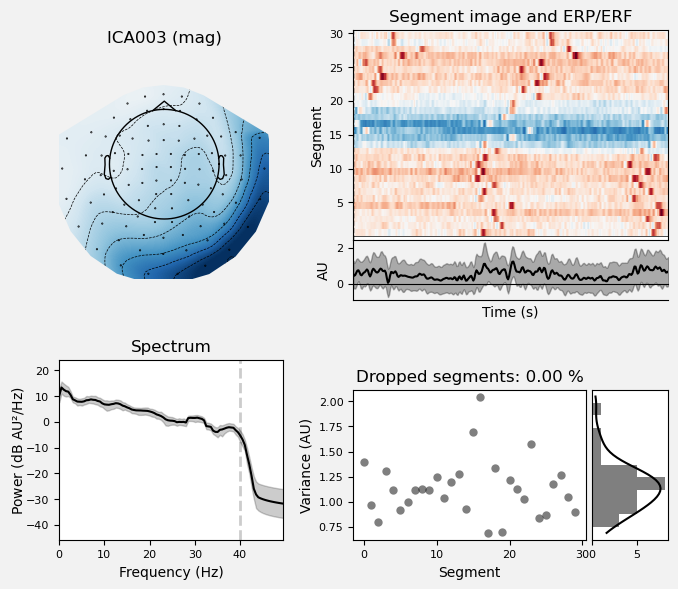

Creating RawArray with float64 data, n_channels=50, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


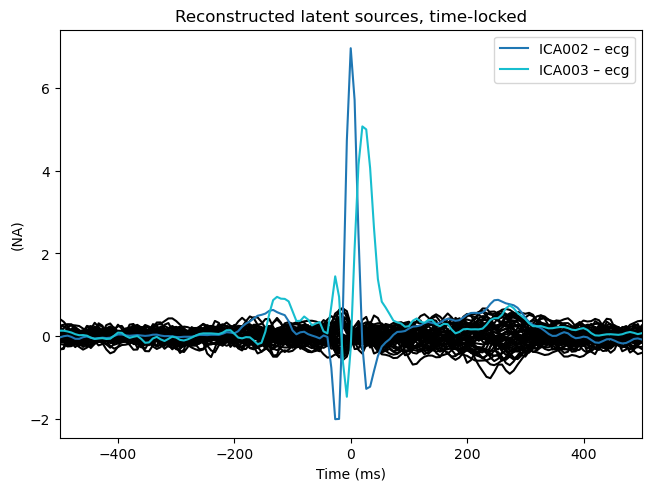

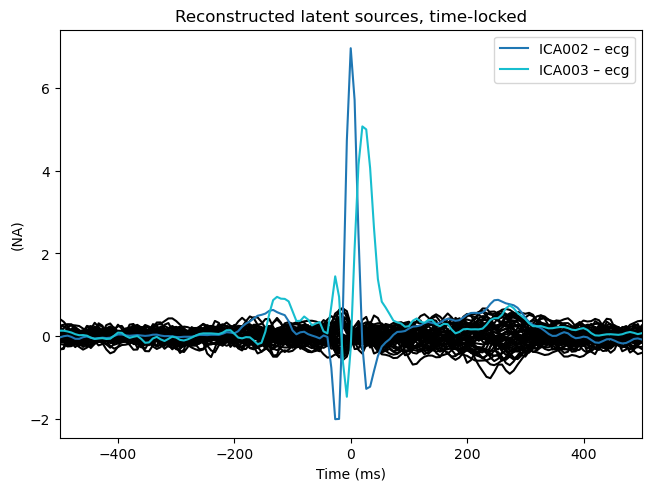

C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


In [35]:
# refit the ICA with more components this time to explain 99% variance
new_ica = ICA(n_components=0.99, max_iter="auto", random_state=97)
new_ica.fit(filt_raw)

# find which ICs match the ECG pattern
ecg_indices, ecg_scores = new_ica.find_bads_ecg(
    raw, method="correlation", threshold="auto"
)
new_ica.exclude = ecg_indices

# barplot of ICA component "ECG match" scores
new_ica.plot_scores(ecg_scores)

# plot diagnostics
new_ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
new_ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
new_ica.plot_sources(ecg_evoked)

Much better! Now we've captured both ICs that are reflecting the heartbeat
artifact (and as a result, we got two diagnostic plots: one for each IC that
reflects the heartbeat). This demonstrates the value of checking the results
of automated approaches like `~mne.preprocessing.ICA.find_bads_ecg`
before accepting them.



For EEG, activation of muscles for postural control of the head and neck
contaminate the signal as well. This is usually not detected by MEG. For
an example showing how to remove these components, see [this example](https://mne.tools/stable/auto_examples/preprocessing/muscle_ica.html).



**Compute ICA components on Epochs**

Note: You should fit the ICA model to data that contain enough instances of the artefact in question. Thus, the model is usually fit on the raw continuous (rather than epoched) data. However, the following example demonstrates how to do this for epoched data if required.

In cases where an artefact is hardly or not at all present, you may not need ICA at all. This can be the case when a participant does not blink a lot, or only blinks in period of no interest (i.e. outside epochs). Heart artefacts may not be an issue for event-related designs, but can be a possible confound for resting state experiments.

ICA is now fit to epoched MEG data instead of the raw data. We assume that the non-stationary EOG artifacts have already been removed (there may not be enough eye blinks in epochs for reliable ICA estimation). The sources matching the ECG are automatically found and displayed.

After reading the data, preprocessing consists of:

* MEG channel selection
* 1-30 Hz band-pass filter
* epoching -0.2 to 0.5 seconds with respect to events
* rejection based on peak-to-peak amplitude

Note that we don't baseline correct the epochs here – we'll do this after cleaning with ICA is completed. Baseline correction before ICA is not recommended by the MNE-Python developers, as it doesn't guarantee optimal results.

In [36]:
filt_raw.pick(picks=["meg", "stim"], exclude="bads").load_data()
filt_raw.filter(1, 30, fir_design="firwin")

# peak-to-peak amplitude rejection parameters
reject = dict(mag=4e-12)
# create longer and more epochs for more artifact exposure
events = mne.find_events(filt_raw, stim_channel="STI 014")
# don't baseline correct epochs
epochs = mne.Epochs(
    filt_raw, events, event_id=None, tmin=-0.2, tmax=0.5, reject=reject, baseline=None
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 s)

86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
86 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
3 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


Fitting ICA to data using 102 channels (please be patient, this may take a while)
Using data from preloaded Raw for 86 events and 106 original time points ...
    Applying projection operator with 3 vectors (pre-whitener computation)
    Applying projection operator with 3 vectors (pre-whitener application)
Selecting by number: 15 components
Using data from preloaded Raw for 86 events and 106 original time points ...
    Applying projection operator with 3 vectors (pre-whitener application)
Fitting ICA took 0.2s.
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.

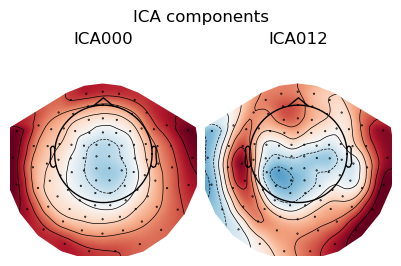

In [43]:
# fit ICA to epochs
ica = ICA(n_components=15, method="fastica", max_iter="auto").fit(epochs)

ecg_epochs = create_ecg_epochs(filt_raw, tmin=-0.5, tmax=0.5)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, threshold="auto")

ica.plot_components(ecg_inds);

Using data from preloaded Raw for 86 events and 106 original time points ...
    Applying projection operator with 3 vectors (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated


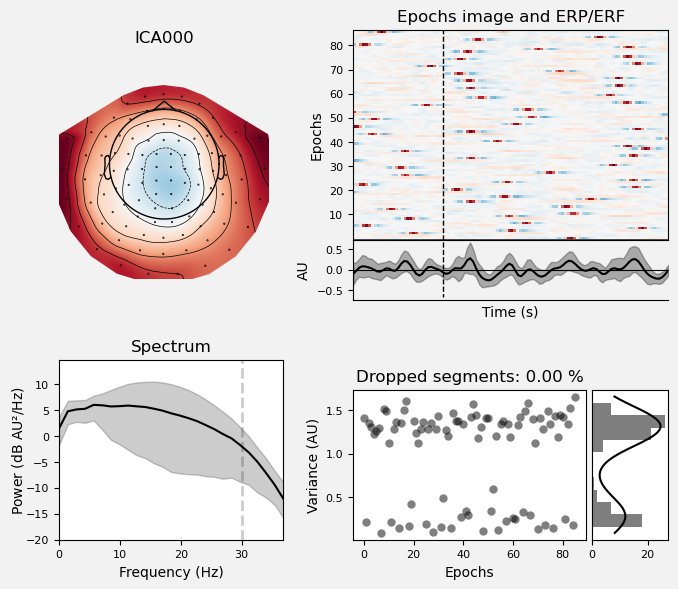

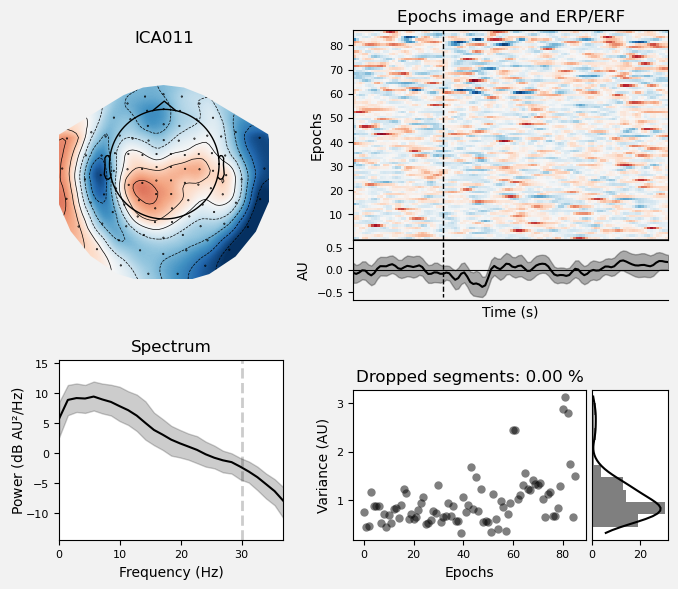

In [41]:
# Plot the properties of the ECG components:
ica.plot_properties(epochs, picks=ecg_inds);

In [42]:
# Plot the estimated sources of detected ECG related components:
ica.plot_sources(filt_raw, picks=ecg_inds);

    Applying projection operator with 3 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=2, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


__Exercise:__ Remove both ECG and EOG artefacts in one step.

## Signal Space Projection (SSP)

The difference between ICA and SSP is similar to multiple versus simple linear regression. ICA takes the correlations between artefact and non-artefact topographies into account, while SSP removes everything from the data that can be explained by the projectors. Thus, SSP uses a more accurate or "purer" estimate for the artefact topography, but may also remove more signal from the data than necessary, i.e. it may overcorrect. SSP can be useful if the artefact cannot be efficiently removed by ICA.

We can compute SSP projectors for the ocular artifact using compute_proj_eog, which again takes a Raw object as input and returns the requested number of projectors for magnetometers, gradiometers, and EEG channels (default is two projectors for each channel type). This time, we’ll pass no_proj parameter (so we get back only the new EOG projectors, not also the existing projectors in the Raw object), and we’ll ignore the events array by assigning it to _ (the conventional way of handling unwanted return elements in Python).

Using EOG channel: EOG 061
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 10 events and 151 original time points 

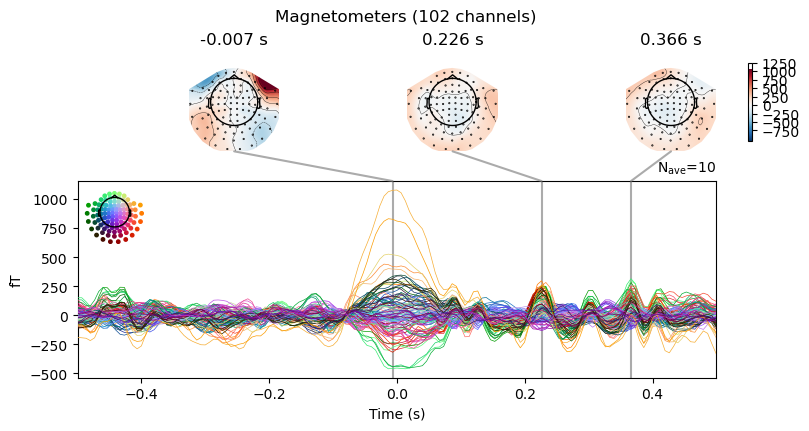

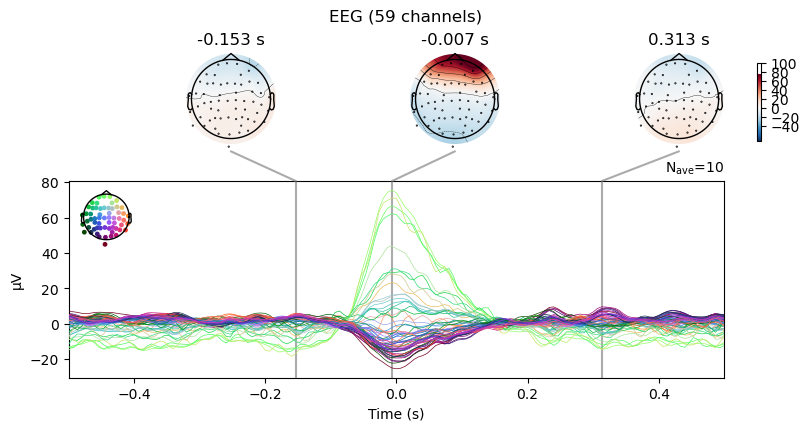

In [46]:
# Let's look at the blink artefact again before applying SSP
eog_evoked = create_eog_epochs(raw).average(picks="all")
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint();

In [47]:
# Compute projections for eye blink topographies
eog_projs, _ = compute_proj_eog(
    raw, n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=True
)

Running EOG SSP computation
Using EOG channel: EOG 061
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Computing projector
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


No channels 'grad' found. Skipping.
Adding projection: axial--0.200-0.200-PCA-01 (exp var=80.0%)
Adding projection: eeg--0.200-0.200-PCA-01 (exp var=98.0%)
Done.


1 projection items deactivated
1 projection items deactivated


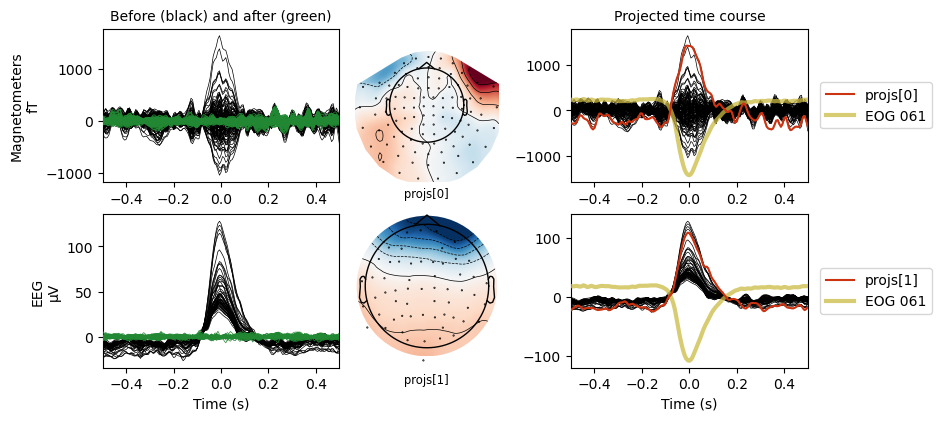

Text(0.5, 0.98, 'EOG projectors')

In [48]:
# Let's see if it works
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked, "eog")
fig.suptitle("EOG projectors")

In [50]:
# add the projections to the raw data (it does not apply them immediately)
raw.add_proj(eog_projs)

2 projection items deactivated


<Raw | sample_audvis_filt-0-40_raw.fif, 172 x 9010 (60.0 s), ~14.9 MiB, data loaded>

In [53]:
# Now plot with...
raw.plot(picks='eeg', proj=True)
# ...and without projection
raw.plot(picks='eeg', proj=False)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x1b700a47a30) at 0x000001B52271EE40>

Channels marked as bad:
['EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
['EEG 053']


You can directly apply the projections to the data for further processing:

In [54]:
raw.apply_proj()

Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...


<Raw | sample_audvis_filt-0-40_raw.fif, 172 x 9010 (60.0 s), ~14.9 MiB, data loaded>

In [56]:
# Now we don't have to mention the projection for plotting anymore
raw.plot(picks='eeg')

<mne_qt_browser._pg_figure.MNEQtBrowser(0x1b5233f56c0) at 0x000001B702C3F400>

Channels marked as bad:
['EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


__Exercise:__ Add projectors for ECG artefacts.